In [1]:
import os
import random

from collections import OrderedDict
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models


from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box, compute_ts_road_map, compute_ats_bounding_boxes
from src import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [4]:
labeled_scene_index = np.arange(106, 134)

train_index = np.arange(106,108)
val_index = np.arange(128,130)

transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=train_index,
    transform=transform,
    extra_info=False
    )

labeled_valset = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=val_index,
    transform=transform,
    extra_info=False
    )

trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [5]:
model = Darknet(num_classes = 10, encoder_features = 6, rm_dim = 800).to(device)
model.load_state_dict(torch.load('../code/PT_FILES/best_threat_yolo02_withPre.pt', map_location=device))

<All keys matched successfully>

In [6]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.transpose(0,1).numpy()[0] * 10 + 400, -point_squence.transpose(0,1).numpy()[1] * 10 + 400, color=color)

torch.Size([30, 2, 4])


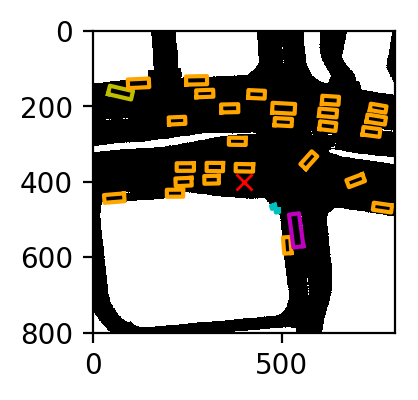

In [7]:
matplotlib.rcParams['figure.figsize'] = [2, 2]

# Visualize results
sample, target, road_image = iter(valloader).next()
image = sample[0].view(-1, 256, 306)

print(target[0]['bounding_box'].shape)

fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

torch.Size([32, 2, 4])


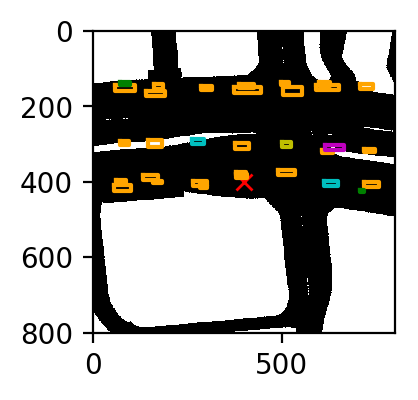

In [8]:
model.eval()
pred_bboxes = model.get_bounding_boxes(sample[0].unsqueeze(0).to(device))[0][0]
print(pred_bboxes.shape)



fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(pred_bboxes.detach()):
    if i < target[0]['bounding_box'].shape[0]:
    # You can check the implementation of the draw box to understand how it works 
        draw_box(ax, bb, color=color_list[target[0]['category'][i]])
    else:
        draw_box(ax, bb, color='g')

In [9]:
compute_ats_bounding_boxes(pred_bboxes, target[0]['bounding_box'])

tensor(0.)

torch.Size([22, 2, 4])


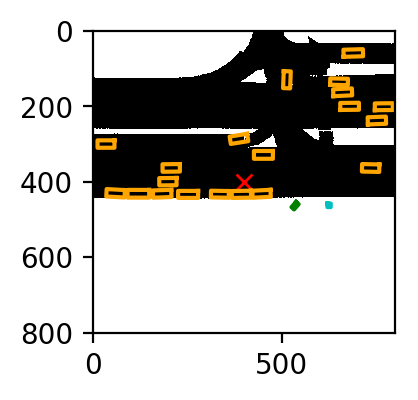

In [10]:
matplotlib.rcParams['figure.figsize'] = [2, 2]

# Visualize results
sample, target, road_image = iter(trainloader).next()
image = sample[0].view(-1, 256, 306)

print(target[0]['bounding_box'].shape)

fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

torch.Size([23, 2, 4])


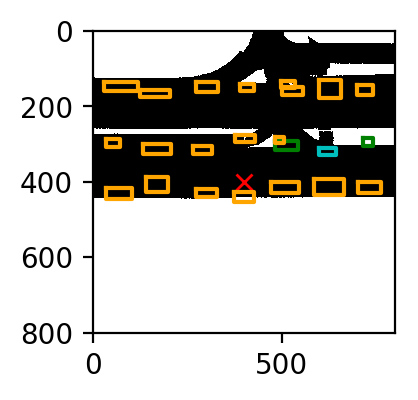

In [11]:
model.eval()
pred_bboxes = model.get_bounding_boxes(sample[0].unsqueeze(0).to(device))[0][0]
print(pred_bboxes.shape)


fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(pred_bboxes.detach()):
    if i < target[0]['bounding_box'].shape[0]:
    # You can check the implementation of the draw box to understand how it works 
        draw_box(ax, bb, color=color_list[target[0]['category'][i]])
    else:
        draw_box(ax, bb, color='g')

In [12]:
compute_ats_bounding_boxes(pred_bboxes, target[0]['bounding_box'])

tensor(0.)